In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random
import dynamical.nonlinear as nl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

In [477]:
def load_res_chan(res_path, chan,load_nnR2=False):
    """
    returns MI, tau, pffn & attr_dim for one channel
    1-indexed (channel 1 is actually channel1 in ecog)
    if load_Rsq is True, load also del_R and attr_size
    """
    
    res_chan = sp.io.loadmat(result_path +'DE_chan' + str(chan) + '.mat', struct_as_record=False, squeeze_me=True)['results']
    MI = np.array([seg.MI for seg in res_chan])
    tau = np.array([seg.tau for seg in res_chan])
    pffn = np.array([seg.pffn for seg in res_chan])
    attr_dim = np.array([seg.attr_dim for seg in res_chan])
    if load_nnR2:
        del_R = np.array([seg.del_R for seg in res_chan])
        attr_size = np.array([seg.attr_size for seg in res_chan])
        return MI, tau, pffn, attr_dim, del_R, attr_size
    else:
        return MI, tau, pffn, attr_dim
    
def ctx_viz(ctx_file, data='none', chans='none', ms=20.):
    """
    plots the cortex image, optionally scale colors by 
    a 1-D data vector
    """
    ctx_mat = sp.io.loadmat(ctx_file, squeeze_me=True)
    if data is not 'none' and chans is 'none':
        #need to fill in channel numbers
        chans = np.arange(len(data))
        
    plt.imshow(ctx_mat['I'])
    if data is 'none':
#        plt.plot(ctx_mat['X'],ctx_mat['Y'], 'ko', ms=ms)
        plt.scatter(ctx_mat['X'],ctx_mat['Y'], marker='o', c='w', s=ms) 
    else:
        plt.scatter(ctx_mat['X'][chans],ctx_mat['Y'][chans], marker='o', s=ms, c=data, cmap='Blues') 
        cbar = plt.colorbar(fraction=0.05)
        cbar.set_ticks([min(data),max(data)])
    
    plt.box('off')    
    plt.xlim([50, 950])
    plt.ylim([1200, 40])
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

In [562]:
exp = '5k_delay_embed_diff_res/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'+exp
recalc_AD = True
max_dim = np.shape(pffn_)[1]
# all channels, skip 63 because broken
channels = np.append(np.arange(1,63), np.arange(64,129))
MI_, tau_, pffn_, attr_dim_ = load_res_chan(result_path,1)
MI = np.zeros((len(channels), np.shape(MI_)[0], np.shape(MI_)[1]))
tau = np.zeros((len(channels), np.shape(tau_)[0]))
AD = np.zeros((len(channels), np.shape(attr_dim_)[0]))
pffn = np.zeros((len(channels), np.shape(pffn_)[0], np.shape(pffn_)[1]))

for idx, chan in enumerate(channels):
    print chan,
    if recalc_AD:
        #recalculate attractor dimension with new params
        MI_, tau_, pffn_, attr_dim_, del_R_, attr_size_ = load_res_chan(result_path, chan, load_nnR2=True)
        for seg in range(len(del_R_)):
            AD[idx,seg], pffn[idx,seg,:] = nl.nn_attractor_dim(del_R_[seg],attr_size_[seg], pffn_thr=0.05, R_thr=15., A_thr=3.)
            
    else:
        MI_, tau_, pffn_, attr_dim_ = load_res_chan(result_path, chan)                
        AD[idx,:] = attr_dim_
        pffn[idx,:,:] = pffn_
    
    MI[idx,:,:] = MI_
    tau[idx,:] = tau_


num_segs = AD.shape[1]
num_conds = 5
num_per_cond = num_segs/num_conds

AD[np.where(AD==-1)] = max_dim+1
print '---'
print len(AD[np.where(AD==(max_dim+1))])*100./np.size(AD), '% above max dimension'

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 ---
4.88188976378 % above max dimension


###### plot results
delay time from MI minimum or attractor dimension

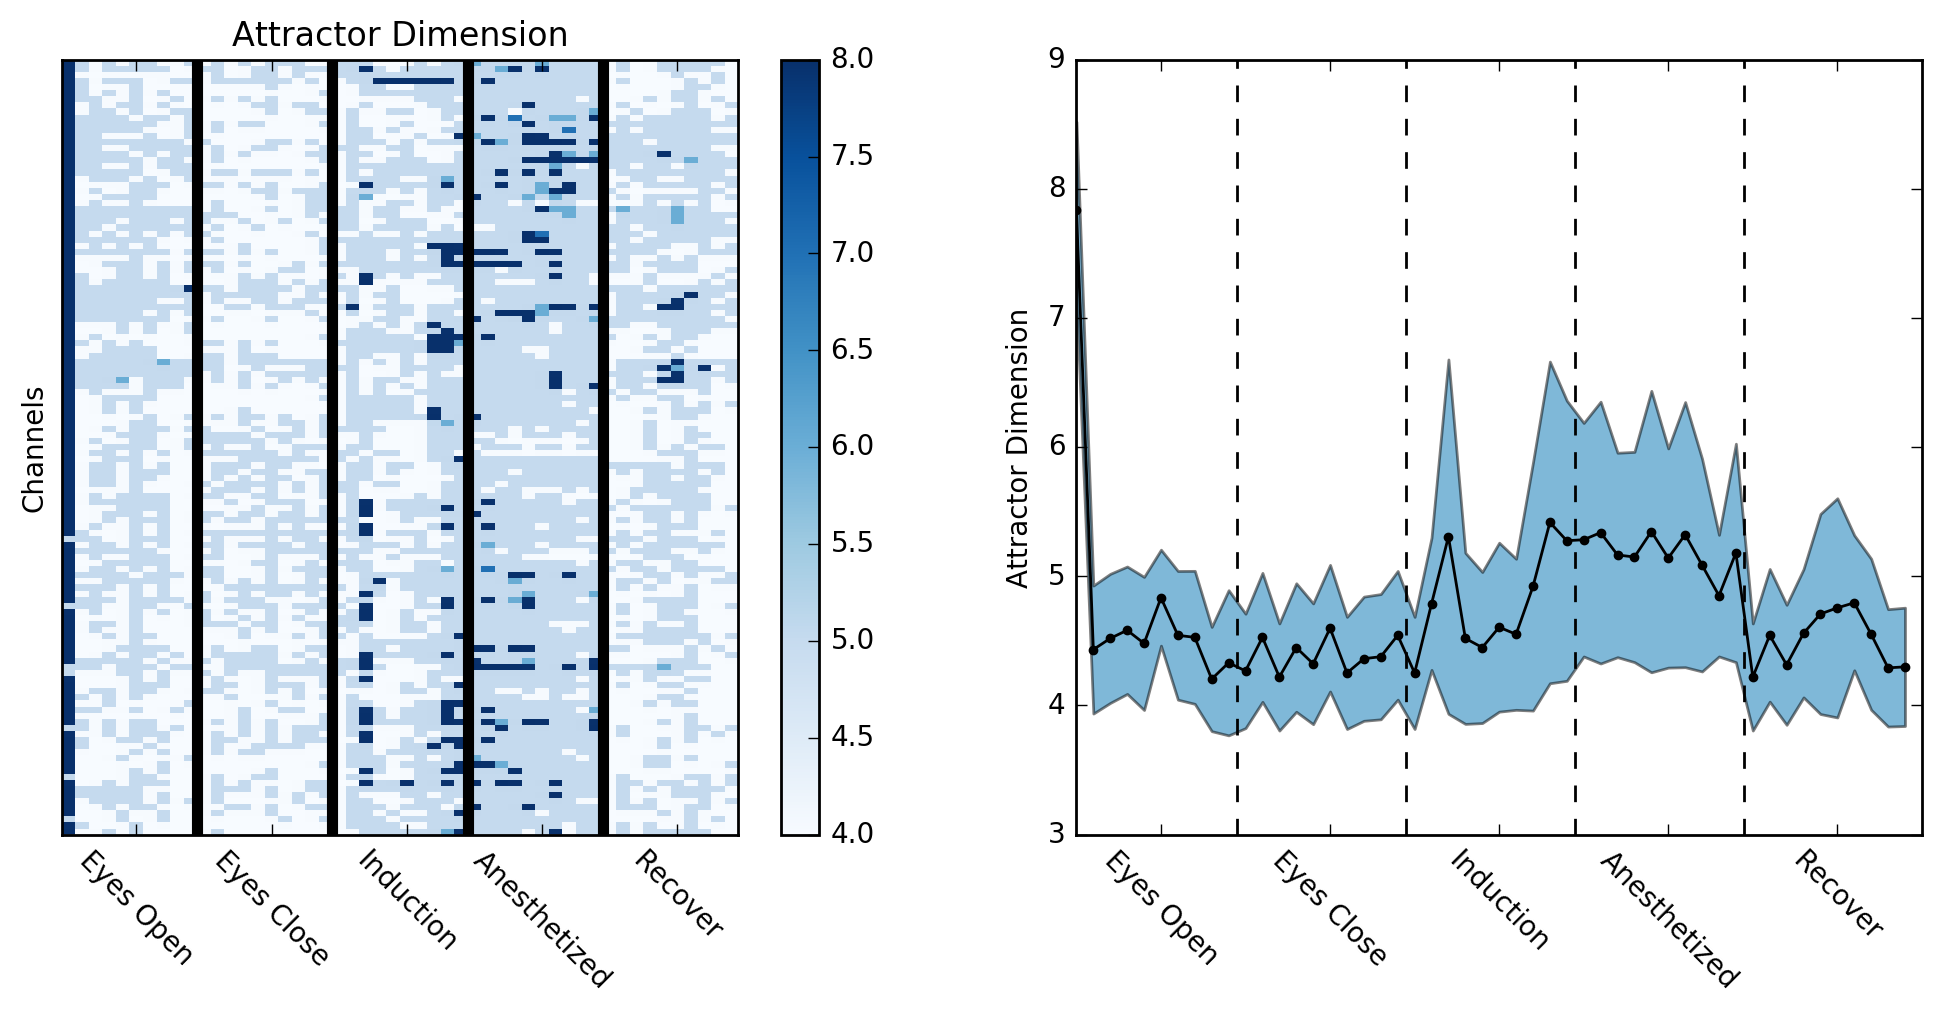

In [563]:
plotting = 'AD'
if plotting is 'AD':
    plot_data = AD
    ti = 'Attractor Dimension'
elif plotting is 'tau':
    plot_data = tau
    ti = 'Delay Tau (samples)'
elif plotting is 'pffn':
    #plot_data = np.min(pffn,axis=2)
    D=5
    plot_data = pffn[:,:,D-1]
    ti = 'Proportion of False NN at D='+str(D)

cond_labels = ['Eyes Open', 'Eyes Close', 'Induction', 'Anesthetized', 'Recover']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(plot_data, interpolation='none', aspect='auto', origin='lower', cmap='Blues')
plt.colorbar()
XL = plt.xlim()
YL = plt.ylim()
plt.xticks(range(num_per_cond/2,num_segs,num_per_cond),cond_labels, rotation=-45)
plt.yticks([])
plt.ylabel('Channels')
plt.plot([np.arange(num_per_cond,num_segs,num_per_cond)-0.5]*2,plt.ylim(), 'k', lw=4)
plt.xlim(XL)
plt.ylim(YL)
plt.title(ti)

plt.subplot(1,2,2)
X_ = np.mean(plot_data,axis=0)
XS_ = np.std(plot_data,axis=0)
plt.fill_between(range(num_segs), X_-XS_, X_+XS_, alpha=0.5)
plt.plot(range(num_segs),X_, 'k.-')
YL = plt.ylim()
plt.plot([np.arange(num_per_cond,num_segs,num_per_cond)-0.5]*2,YL, 'k--', lw=1)
plt.ylim(YL)
plt.xticks(range(num_per_cond/2,num_segs,num_per_cond),cond_labels, rotation=-45);
plt.ylabel(ti)

###### plot result on a brain

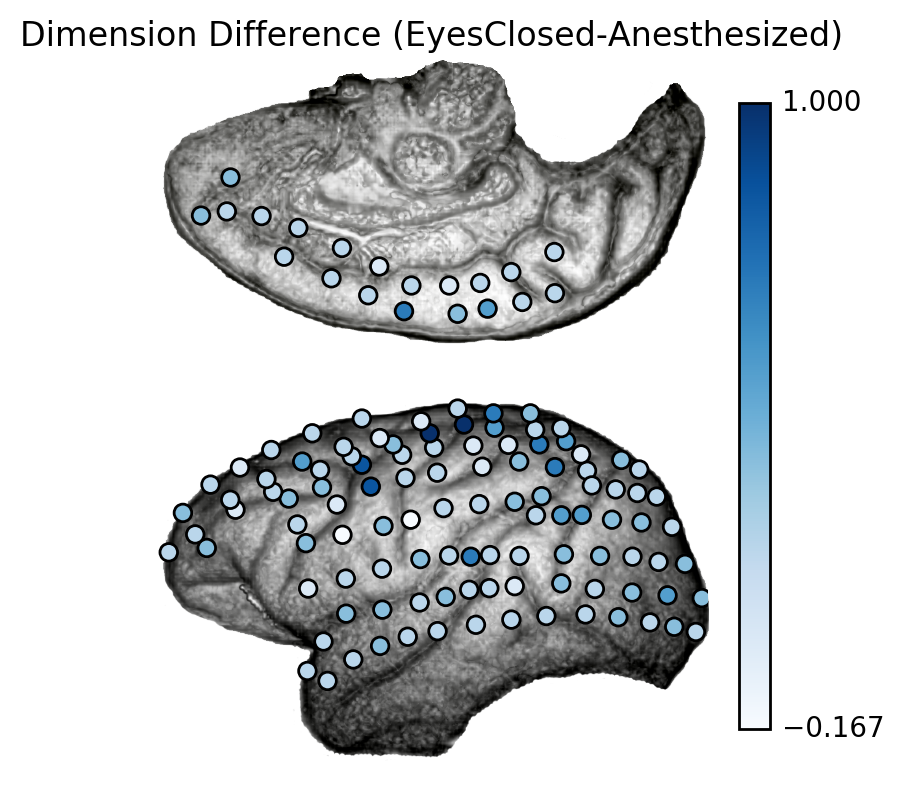

In [559]:
ctx_file = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
plt.figure(figsize=(4,4))
#data = np.array([ch[15] for ch in tau])
data = np.mean(AD[:,1:6],axis=1)-np.mean(AD[:,6:12],axis=1)
data = np.mean(AD[:,6:12],axis=1)-np.mean(AD[:,18:24],axis=1)
ctx_viz(ctx_file, data=data, chans = channels-1, ms=40.)
plt.title('Dimension Difference (EyesClosed-Anesthesized)')
#ctx_viz(ctx_file, ms=40.)

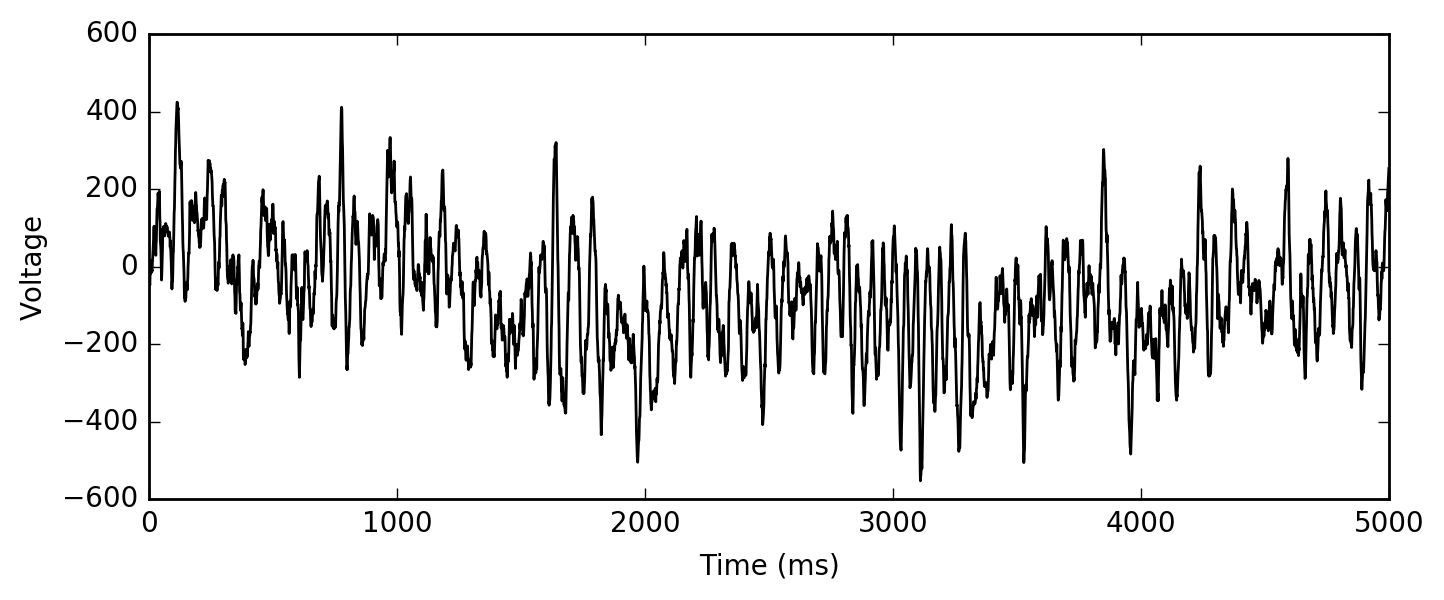

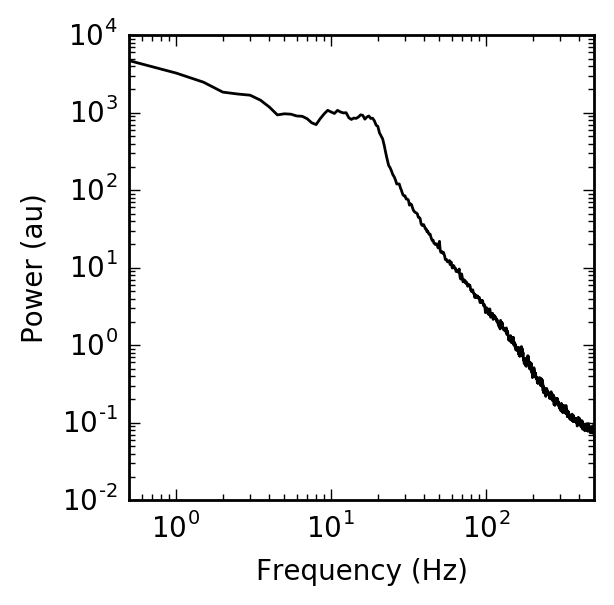

In [500]:
# plot raw data & PSD
channel = 1
session = 1
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'

matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
ecog = matfile['ECoGData_ch'+str(channel)]
data = ecog[timefile['ConditionIndex'][2]:timefile['ConditionIndex'][3]]
plt.figure(figsize=(8,3))
plt.plot(data[:5000],'k')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.figure(figsize=(3,3))
fs = 1000.
f_axis, PSD = sig.welch(data,fs=fs, nperseg=int(fs*2), noverlap=int(fs/2),)
plt.loglog(f_axis, PSD, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (au)')
plt.xlim(f_axis[0], f_axis[-1]);